# MATH50003 Numerical Analysis (2022–23)
# Lab 4: Structured Matrices

This lab explores the basics of arrays (matrices and vectors)
in Julia. We also investigate implementation of triangular solves,
supporting a matrix with two super-diagonals.

Note in programming there are often different ways to do the same thing.
so some of the hints suggest multiple ways to solve the same problem.
Remember you can use `?` to discover the functions mentioned in the hints.

In [16]:
using LinearAlgebra, Test

# We will override these functions below
import Base: getindex, setindex!, size, *, \

## 1. Array creation

One can create arrays in multiple ways. For example, the function `zeros(Int, 10)` creates
a 10-element `Vector` whose entries are all `zero(Int) == 0`. Or `fill(x, 10)` creates a
10-element `Vector` whose entries are all equal to `x`. Or you can use a comprehension:
for example `[k^2 for k = 1:10]` creates a vector whose entries are `[1^2, 2^2, …, 10^2]`.
This also works for matrices: `zeros(Int, 10, 5)` creates a 10 × 5 matrix of all zeros,
and `[k^2 + j for k=1:3, j=1:4]` creates the following:

In [2]:
[k^2 + j for k=1:3, j=1:4]

4×3 Matrix{Int64}:
 2  5  10
 3  6  11
 4  7  12
 5  8  13

Note sometimes it is best to create a vector/matrix and populate it. For example, the
previous matrix could also been constructed as follows:

In [5]:
A = zeros(Int, 3, 4)
for k = 1:3, j = 1:4
    A[k,j] = k^2 + j
end
A

3×4 Matrix{Int64}:
  2   3   4   5
  5   6   7   8
 10  11  12  13

**Problem 1.1** Create a vector of length 5 whose entries are `Int` which is
zero in all entries. Hint: use `zeros`, `fill`, or a comprehension.

In [4]:
B = zeros(Int, 5)

5-element Vector{Int64}:
 0
 0
 0
 0
 0

**Problem 1.2** Create a 5×6 matrix whose entries are `Int` which is
one in all entries. Hint: use a for-loop, `ones`, `fill`, or a comprehension.

In [6]:
C = ones(Int, 5, 6)

5×6 Matrix{Int64}:
 1  1  1  1  1  1
 1  1  1  1  1  1
 1  1  1  1  1  1
 1  1  1  1  1  1
 1  1  1  1  1  1

**Problem 1.3** Create a 1 × 5 `Matrix{Int}` with entries `A[k,j] = j`. Hint: use a for-loop or a comprehension.

In [8]:
D = zeros(Int, 1, 5)
for j = 1:5
    D[1,j] = j
end
D

1×5 Matrix{Int64}:
 1  2  3  4  5

**Problem 1.4** Create a vector of length 5 whose entries are `Float64`
approximations of `exp(-k)`. Hint: one use a for-loop or broadcasting `f.(x)` notation.

In [12]:
E = [k for k = -1:-1:-5]
exp.(E)

5-element Vector{Float64}:
 0.36787944117144233
 0.1353352832366127
 0.049787068367863944
 0.01831563888873418
 0.006737946999085467

**Problem 1.5** Create a 5 × 6 matrix `A` whose entries `A[k,j] == cos(k+j)`.

In [14]:
F = [k + j for k = 1:5, j = 1:6]
cos.(F)

5×6 Matrix{Float64}:
 -0.416147  -0.989992  -0.653644   0.283662   0.96017    0.753902
 -0.989992  -0.653644   0.283662   0.96017    0.753902  -0.1455
 -0.653644   0.283662   0.96017    0.753902  -0.1455    -0.91113
  0.283662   0.96017    0.753902  -0.1455    -0.91113   -0.839072
  0.96017    0.753902  -0.1455    -0.91113   -0.839072   0.0044257

## 2. Dense Matrices

The following problem compares the behaviour of `mul_cols` defined in lectures

In [17]:
function mul_cols(A, x)
    m,n = size(A)
    c = zeros(eltype(x), m) # eltype is the type of the elements of a vector/matrix
    for j = 1:n, k = 1:m
        c[k] += A[k, j] * x[j]
    end
    c
end

mul_cols (generic function with 1 method)

to the inbuilt matrix-vector multiplication operation `A*x`. The point is that
sometimes the choice of algorithm, despite being mathematically equivalent, can change the exact results
when using floating point.

**Problem 2** Show that `A*x` is not
implemented as `mul_cols(A, x)` from the lecture notes
by finding a `Float64` example  where the bits do not match.
Hint: either guess-and-check, perhaps using `randn(n,n)` to make a random `n × n` matrix.

In [28]:
using ColorBitstring
n = 5
A = rand(n, n)
x = ones(Float64, n)

[(A * x - mul_cols(A, x))]

1-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0]

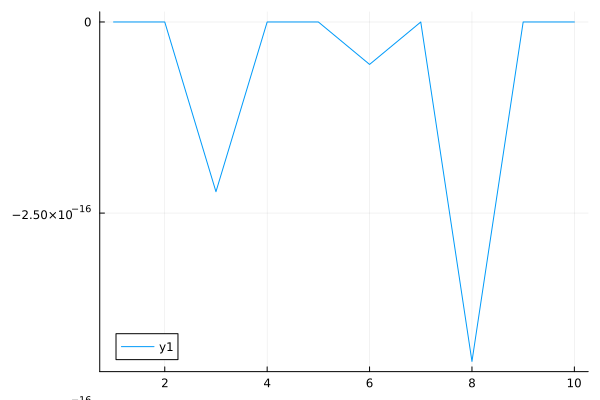

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\antho\.julia\packages\PlotUtils\M092a\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\antho\.julia\packages\PlotUtils\M092a\src\ticks.jl:191


In [38]:
using Plots

function findblasmuldifference(n, l)
	for j = 1:n
		A = randn(l,l)
		x = rand(l)
		if A*x != mul_cols(A,x)
			return (A,x)
		end
	end
end

n = 100 # number of attempts
l = 10 # size of objects
A,x = findblasmuldifference(n,l) # find a difference

error = -(A*x - mul_cols(A, x))
plot(error)
#, yaxis =:log10)

## 3. Triangular Matrices

In lectures we covered algorithms involving upper-triangular matrices. Here we want to implement
the lower-triangular analogues.

**Problem 3.1** Complete the following function for lower triangular matrix-vector
multiplication without ever accessing the zero entries of `L` above the diagonal.
Hint: just copy code for `mul_cols` and modify the for-loop ranges a la the `UpperTriangular`
case.

In [45]:
function mul_cols(L::LowerTriangular, x)
    n = size(L,1)

    # promote_type type finds a type that is compatible with both types, eltype gives the type of the elements of a vector / matrix
    T = promote_type(eltype(x),eltype(L))
    b = zeros(T,n) # the returned vector, begins of all zeros

    # TODO: populate b so that L*x ≈ b
    for j = 1:n, k = j:n
        b[k] += L[k, j] * x[j]
    end

    b
end

L = LowerTriangular(randn(5,5))
x = randn(5)
L*x - mul_cols(L, x)
@test L*x ≈ mul_cols(L, x)

Test Passed

**Problem 3.2** Complete the following function for solving linear systems with
lower triangular systems by implementing forward-substitution.

In [48]:
function ldiv(L::LowerTriangular, b)
    n = size(L,1)

    if length(b) != n
        error("The system is not compatible")
    end

    x = zeros(n)  # the solution vector
    # TODO: populate x using forward-substitution so that L*x ≈ b
    for i = 1:n
        var = b[i]
        for j = 1:(i-1)
            var -= L[i, j]*x[j]
        end
        x[i] = var/L[i, i]
    end
    x
end


L = LowerTriangular(randn(5,5))
b = randn(5)
@test L\b ≈ ldiv(L, b)

Test Passed

## 4. Banded matrices

Banded matrices are very important in differential equations and enable much faster algorithms.
Here we look at banded upper triangular matrices by implementing a type that encodes this
property:

In [51]:
struct UpperTridiagonal{T} <: AbstractMatrix{T}
    d::Vector{T}   # diagonal entries: d[k] == U[k,k]
    du::Vector{T}  # super-diagonal enries: du[k] == U[k,k+1]
    du2::Vector{T} # second-super-diagonal entries: du2[k] == U[k,k+2]
end

This uses the notation `<: AbstractMatrix{T}`: this tells Julia that our type is in fact a matrix.
In order for it to behave a matrix we have to overload the function `size` for our type to return
the dimensions (in this case we just use the length of the diagonal):

In [52]:
size(U::UpperTridiagonal) = (length(U.d),length(U.d))

size (generic function with 120 methods)

Julia still doesn't know what the entries of the matrix are. To do this we need to overload `getindex`.
We also overload `setindex!` to allow changing the non-zero entries.

**Problem 4.1** Complete the implementation of `UpperTridiagonal` which represents a banded matrix with
bandwidths $(l,u) = (0,2)$ by overloading `getindex` and `setindex!`. Return zero (of the same type as the other entries)
if we are off the bands.

In [61]:
# getindex(U, k, j) is another way to write U[k,j].
# This function will therefore be called when we call U[k,j]
function getindex(U::UpperTridiagonal, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    # TODO: return U[k,j]
    if k == j
        return d[k]
    elseif k+1 == j 
        return du[k]
    elseif k+2 == j
        return du2[k]
    else
        return 0
    end

end

# setindex!(U, v, k, j) gets called when we write (U[k,j] = v).
function setindex!(U::UpperTridiagonal, v, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    if j > k+2 || j < k
        error("Cannot modify off-band")
    end

    if k == j
        d[k] = v
    elseif k+1 == j 
        du[k] = v
    elseif k+2 == j
        du2[k] = v
    end    
    # TODO: modify d,du,du2 so that U[k,j] == v

    U # by convention we return the matrix
end

U = UpperTridiagonal([1,2,3,4,5], [1,2,3,4], [1,2,3])
@test U == [1 1 1 0 0;
            0 2 2 2 0;
            0 0 3 3 3;
            0 0 0 4 4;
            0 0 0 0 5]

U[3,4] = 2
@test U == [1 1 1 0 0;
            0 2 2 2 0;
            0 0 3 2 3;
            0 0 0 4 4;
            0 0 0 0 5]

Test Passed

**Problem 4.2** Complete the following implementations of `*` and `\` for `UpperTridiagonal` so that
they take only $O(n)$ operations. Hint: the function `max(a,b)` returns the larger of `a` or `b`
and `min(a,b)` returns the smaller. They may help to avoid accessing zeros.

In [70]:
function *(U::UpperTridiagonal, x::AbstractVector)
    n = size(U,1)
    # promote_type type finds a type that is compatible with both types, eltype gives the type of the elements of a vector / matrix
    T = promote_type(eltype(x),eltype(U))
    b = zeros(T, n) # the returned vector, begins of all zeros
    # TODO: populate b so that U*x ≈ b (up to rounding)
    for k = 1:n-2, j = k:k+2
        b[k] += U[k, j] * x[j]
    end
    b[n-1] = U[n-1, n-1]*x[n-1] + U[n-1, n]*x[n]
    b[n] = U[n,n]*x[n]
    b
end

function \(U::UpperTridiagonal, b::AbstractVector)
    n = size(U,1)
    T = promote_type(eltype(b),eltype(U))

    if length(b) != n
        error("The system is not compatible")
    end

    x = zeros(T, n)  # the solution vector
    ## TODO: populate x so that U*x ≈ b
    x[n] = b[n] / U[n,n]
    x[n-1] = (b[n-1] - U[n-1, n]*x[n])/U[n-1, n-1]
    for k = n-2:-1:1  # start with k=n, then k=n-1, ...
        r = b[k]  # dummy variable
        for j = k+1:k+2
            r -= U[k,j]*x[j] # equivalent to r = r - U[k,j]*x[j]
        end
        # after this for loop, r = b[k] - ∑_{j=k+1}^n U[k,j]x[j]  
        x[k] = r/U[k,k]
    end
    x
end

n = 1_000_000 # under-scores are like commas: so this is a million: 1,000,000
U = UpperTridiagonal(ones(n), fill(0.5,n-1), fill(0.1,n-2))
x = ones(n)
b = [fill(1.6,n-2); 1.5; 1] # exact result
# note following should take much less than a second
@test U*x ≈ b
@test U\b ≈ x

Test Passed

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*